# 1. Import Libraries

In [30]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import requests
from io import BytesIO
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, DenseNet169, Xception, ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# 2. Load Dataset

### 2.1 Define GitHub Repo & Folder Path

In [2]:
GITHUB_REPO = "prattapong/Commercial-Airplane-Model-Image-Classification"
GITHUB_FOLDER = "images"
GITHUB_API_URL = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{GITHUB_FOLDER}"

### 2.2 Fetch Image URLs and Load Image

In [3]:
# Fetch Image URLs Automatically
def get_image_urls():
    response = requests.get(GITHUB_API_URL)
    if response.status_code != 200:
        raise Exception(f"Error fetching images: {response.json()}")

    image_urls = {}
    for folder in response.json():
        if folder["type"] == "dir":  # Ensure it's a folder (A350, B787, A320)
            class_name = folder["name"]
            image_urls[class_name] = []
            folder_url = folder["url"]

            # Fetch image files in each class folder
            folder_response = requests.get(folder_url)
            if folder_response.status_code == 200:
                for file in folder_response.json():
                    if file["name"].lower().endswith((".jpg", ".jpeg", ".png")):
                        image_urls[class_name].append(file["download_url"])

    return image_urls

# Load Images Using Image.open()
def load_images(image_urls):
    IMG_SIZE = (224, 224)  # Resize all images to 224x224
    X, y = [], []

    total_images = sum(len(urls) for urls in image_urls.values())  # Total number of images
    progress_bar = tqdm(total=total_images, desc="Loading Images", unit="img")

    for label, urls in image_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content)).convert("RGB")  # Load image
                img = img.resize(IMG_SIZE)
                X.append(np.array(img) / 255.0)  # Normalize
                y.append(label)
            except Exception as e:
                print(f"Error loading {url}: {e}")
            progress_bar.update(1)  # Update progress bar

    progress_bar.close()
    return np.array(X), pd.Categorical(y).codes

{'Airbus A32': 'link'}

# 3. Data-preprocessing

In [4]:
def augment_data(X_train):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    datagen.fit(X_train)

    return datagen

# 4. Train model

### 4.1 List 5 pre-trained models

In [5]:
MODELS = {
    "ResNet50": ResNet50,
    "EfficientNetB3": EfficientNetB3,
    "DenseNet169": DenseNet169,
    "Xception": Xception,
    "ConvNeXtBase": ConvNeXtBase
}

### 4.2 Initiate training loop

In [6]:
def train_and_evaluate_model(model_name, X, y, batch_size, epochs, learning_rate, dropout_rate, num_unfreezed_layers=0):
    print(f"Training {model_name} with LR={learning_rate}, Dropout={dropout_rate}...")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=244
    )

    base_model = MODELS[model_name](weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    ############## Hyper 1: Change original weight ##############
    if num_unfreezed_layers == 0:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers[-num_unfreezed_layers:]:
            layer.trainable = True

    ############## Hyper 2: Customize additional layer ##############
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(len(set(y)), activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    datagen = augment_data(X_train)
    checkpoint = ModelCheckpoint(f'best_{model_name}.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        callbacks=[checkpoint])

    best_model = tf.keras.models.load_model(f'best_{model_name}.h5')
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")

    return model_name, test_accuracy, history

def compare_models(X, y, learning_rates, dropout_rates, batch_sizes, num_unfreezed_layers, epochs=50):
    results = []
    for model_name in MODELS.keys():
        for lr in learning_rates:
            for dr in dropout_rates:
                for batch_size in batch_sizes:
                    result = train_and_evaluate_model(model_name, X, y, batch_size, epochs, lr, dr, num_unfreezed_layers)
                    results.append(result)

    # Sort by accuracy
    results.sort(key=lambda x: x[1], reverse=True)
    print("\nModel Performance Ranking:")
    for rank, (model_name, accuracy, _) in enumerate(results, 1):
        print(f"{rank}. {model_name}: {accuracy:.4f}")

    return results

In [7]:
image_urls = get_image_urls()
X, y = load_images(image_urls)

Loading Images: 100%|██████████| 605/605 [03:17<00:00,  3.06img/s]


### 4.3 Set Hyper-parameter

In [9]:
num_unfreezed_layers = 0
learning_rates = [0.0001]
dropout_rates = [0.2]
batch_sizes = [8]

### 4.4 Train all models and parameters

In [10]:
best_model = compare_models(
    X = X,
    y = y,
    epochs = 20,

    ############## Hyper-parameter ##############
    learning_rates = learning_rates,
    dropout_rates = dropout_rates,
    batch_sizes = batch_sizes,
    num_unfreezed_layers = num_unfreezed_layers
)

Training ResNet50 with LR=0.0001, Dropout=0.2...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3053 - loss: 1.2153
Epoch 1: val_accuracy improved from -inf to 0.35537, saving model to best_ResNet50.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 348ms/step - accuracy: 0.3059 - loss: 1.2150 - val_accuracy: 0.3554 - val_loss: 1.1027
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3420 - loss: 1.1641
Epoch 2: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.3416 - loss: 1.1644 - val_accuracy: 0.3471 - val_loss: 1.1171
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3672 - loss: 1.1411
Epoch 3: val_accuracy improved from 0.35537 to 0.36364, saving model to best_ResNet50.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3669 - loss: 1.1412 - val_accuracy: 0.3636 - val_loss: 1.0970
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3647 - loss: 1.1332
Epoch 4: val_accuracy did not improve from 0.36364
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.3644 - loss: 1.1334 - val_accuracy: 0.3306 - val_loss: 1.1066
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3269 - loss: 1.1483
Epoch 5: val_accuracy improved from 0.36364 to 0.47107, saving model to best_ResNet50.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.3267 - loss: 1.1485 - val_accuracy: 0.4711 - val_loss: 1.0889
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2936 - loss: 1.1669
Epoch 6: val_accuracy did not improve from 0.47107
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.2936 - loss: 1.1668 - val_accuracy: 0.3967 - val_loss: 1.0863
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3564 - loss: 1.1245
Epoch 7: val_accuracy did not improve from 0.47107
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.3558 - loss: 1.1246 - val_accuracy: 0.3554 - val_loss: 1.0832
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3794 - loss: 1.0947
Epoch 8: val_accuracy did not improve from 0.47107
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.3792 - loss: 1.0948 - val_accuracy: 0.3636 - val_loss: 1.0813
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3514 - loss: 1.1211
Epoch 9: val_accuracy did not improve 

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.3757 - loss: 1.1072 - val_accuracy: 0.5124 - val_loss: 1.0769
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3630 - loss: 1.0916
Epoch 11: val_accuracy did not improve from 0.51240
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3632 - loss: 1.0916 - val_accuracy: 0.4628 - val_loss: 1.0785
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3938 - loss: 1.0816
Epoch 12: val_accuracy did not improve from 0.51240
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3936 - loss: 1.0817 - val_accuracy: 0.4628 - val_loss: 1.0729
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3754 - loss: 1.0923
Epoch 13: val_accuracy did not improve from 0.51240
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.3755 - loss: 1.0922 - val_accuracy: 0.3554 - val_loss: 1.0766
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3817 - loss: 1.0831
Epoch 14: val_accuracy did no

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3947 - loss: 1.0729 - val_accuracy: 0.5207 - val_loss: 1.0655
Epoch 19/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4083 - loss: 1.0800
Epoch 19: val_accuracy did not improve from 0.52066
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.4082 - loss: 1.0801 - val_accuracy: 0.3719 - val_loss: 1.0649
Epoch 20/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4360 - loss: 1.0630
Epoch 20: val_accuracy did not improve from 0.52066
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.4355 - loss: 1.0632 - val_accuracy: 0.3223 - val_loss: 1.0719


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.4895 - loss: 1.0672
ResNet50 Test Accuracy: 0.5207
Training EfficientNetB3 with LR=0.0001, Dropout=0.2...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.3217 - loss: 1.1412
Epoch 1: val_accuracy improved from -inf to 0.35537, saving model to best_EfficientNetB3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 801ms/step - accuracy: 0.3219 - loss: 1.1409 - val_accuracy: 0.3554 - val_loss: 1.1012
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3727 - loss: 1.1111
Epoch 2: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3723 - loss: 1.1111 - val_accuracy: 0.3554 - val_loss: 1.1015
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3060 - loss: 1.1224
Epoch 3: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3063 - loss: 1.1223 - val_accuracy: 0.3554 - val_loss: 1.0994
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3293 - loss: 1.1081
Epoch 4: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.3297 - loss: 1.1081 - val_accuracy: 0.3554 - val_loss: 1.0998
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3552 - loss: 1.1014
Epoch 5: val_accuracy did not improve

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3266 - loss: 1.1214 - val_accuracy: 0.3719 - val_loss: 1.1002
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3349 - loss: 1.1024
Epoch 10: val_accuracy did not improve from 0.37190
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.3351 - loss: 1.1024 - val_accuracy: 0.3554 - val_loss: 1.1030
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3499 - loss: 1.0978
Epoch 11: val_accuracy did not improve from 0.37190
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3502 - loss: 1.0977 - val_accuracy: 0.3554 - val_loss: 1.1016
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3655 - loss: 1.1006
Epoch 12: val_accuracy did not improve from 0.37190
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.3650 - loss: 1.1007 - val_accuracy: 0.3058 - val_loss: 1.1052
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3840 - loss: 1.0908
Epoch 13: val_accuracy did not 

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3633 - loss: 1.1033
EfficientNetB3 Test Accuracy: 0.3719
Training DenseNet169 with LR=0.0001, Dropout=0.2...
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3877 - loss: 1.1841
Epoch 1: val_accuracy improved from -inf to 0.52893, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3877 - loss: 1.1841 - val_accuracy: 0.5289 - val_loss: 0.9959
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5058 - loss: 1.0683
Epoch 2: val_accuracy improved from 0.52893 to 0.60331, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.5061 - loss: 1.0671 - val_accuracy: 0.6033 - val_loss: 0.9300
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5999 - loss: 0.8731
Epoch 3: val_accuracy improved from 0.60331 to 0.61157, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.5995 - loss: 0.8741 - val_accuracy: 0.6116 - val_loss: 0.9097
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5934 - loss: 0.8829
Epoch 4: val_accuracy improved from 0.61157 to 0.66116, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5935 - loss: 0.8823 - val_accuracy: 0.6612 - val_loss: 0.8637
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6309 - loss: 0.8203
Epoch 5: val_accuracy improved from 0.66116 to 0.68595, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6312 - loss: 0.8200 - val_accuracy: 0.6860 - val_loss: 0.8154
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6883 - loss: 0.7166
Epoch 6: val_accuracy did not improve from 0.68595
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.6884 - loss: 0.7167 - val_accuracy: 0.6364 - val_loss: 0.8287
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6969 - loss: 0.7258
Epoch 7: val_accuracy improved from 0.68595 to 0.70248, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6969 - loss: 0.7258 - val_accuracy: 0.7025 - val_loss: 0.7794
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6905 - loss: 0.6993
Epoch 8: val_accuracy did not improve from 0.70248
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6908 - loss: 0.6993 - val_accuracy: 0.6942 - val_loss: 0.7843
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7274 - loss: 0.6608
Epoch 9: val_accuracy improved from 0.70248 to 0.72727, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.7275 - loss: 0.6608 - val_accuracy: 0.7273 - val_loss: 0.7745
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7078 - loss: 0.6575
Epoch 10: val_accuracy improved from 0.72727 to 0.73554, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7084 - loss: 0.6571 - val_accuracy: 0.7355 - val_loss: 0.7253
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7373 - loss: 0.6095
Epoch 11: val_accuracy did not improve from 0.73554
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.7376 - loss: 0.6094 - val_accuracy: 0.7190 - val_loss: 0.7320
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7995 - loss: 0.5497
Epoch 12: val_accuracy did not improve from 0.73554
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.7990 - loss: 0.5501 - val_accuracy: 0.7273 - val_loss: 0.7641
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7442 - loss: 0.5797
Epoch 13: val_accuracy improved from 0.73554 to 0.74380, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7445 - loss: 0.5798 - val_accuracy: 0.7438 - val_loss: 0.7285
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7690 - loss: 0.5691
Epoch 14: val_accuracy improved from 0.74380 to 0.76033, saving model to best_DenseNet169.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.7693 - loss: 0.5687 - val_accuracy: 0.7603 - val_loss: 0.7048
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8035 - loss: 0.5369
Epoch 15: val_accuracy did not improve from 0.76033
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8034 - loss: 0.5369 - val_accuracy: 0.7521 - val_loss: 0.6883
Epoch 16/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7591 - loss: 0.5740
Epoch 16: val_accuracy did not improve from 0.76033
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.7596 - loss: 0.5733 - val_accuracy: 0.7273 - val_loss: 0.7735
Epoch 17/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7523 - loss: 0.5490
Epoch 17: val_accuracy did not improve from 0.76033
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7526 - loss: 0.5489 - val_accuracy: 0.7273 - val_loss: 0.7347
Epoch 18/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7985 - loss: 0.5395
Epoch 18: val_accuracy did not 

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7448 - loss: 0.7362
DenseNet169 Test Accuracy: 0.7603
Training Xception with LR=0.0001, Dropout=0.2...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4011 - loss: 1.1082
Epoch 1: val_accuracy improved from -inf to 0.47934, saving model to best_Xception.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step - accuracy: 0.4013 - loss: 1.1080 - val_accuracy: 0.4793 - val_loss: 1.0264
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5085 - loss: 1.0082
Epoch 2: val_accuracy improved from 0.47934 to 0.53719, saving model to best_Xception.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5084 - loss: 1.0080 - val_accuracy: 0.5372 - val_loss: 0.9795
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5534 - loss: 0.9699
Epoch 3: val_accuracy did not improve from 0.53719
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.5533 - loss: 0.9700 - val_accuracy: 0.5289 - val_loss: 0.9688
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5503 - loss: 0.9516
Epoch 4: val_accuracy did not improve from 0.53719
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.5501 - loss: 0.9514 - val_accuracy: 0.5372 - val_loss: 0.9210
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6036 - loss: 0.8985
Epoch 5: val_accuracy did not improve from 0.53719
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6034 - loss: 0.8984 - val_accuracy: 0.5124 - val_loss: 0.9783
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5435 - loss: 0.9301
Epoch 6: val_accuracy did not improve

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6654 - loss: 0.8009 - val_accuracy: 0.5702 - val_loss: 0.9106
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6693 - loss: 0.8079
Epoch 11: val_accuracy improved from 0.57025 to 0.57851, saving model to best_Xception.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.6691 - loss: 0.8078 - val_accuracy: 0.5785 - val_loss: 0.9029
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6793 - loss: 0.7792
Epoch 12: val_accuracy did not improve from 0.57851
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6790 - loss: 0.7796 - val_accuracy: 0.5537 - val_loss: 0.9260
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6534 - loss: 0.8200
Epoch 13: val_accuracy improved from 0.57851 to 0.59504, saving model to best_Xception.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.6535 - loss: 0.8199 - val_accuracy: 0.5950 - val_loss: 0.8902
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6979 - loss: 0.7703
Epoch 14: val_accuracy did not improve from 0.59504
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6978 - loss: 0.7705 - val_accuracy: 0.5620 - val_loss: 0.9482
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6737 - loss: 0.7734
Epoch 15: val_accuracy did not improve from 0.59504
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6739 - loss: 0.7735 - val_accuracy: 0.5868 - val_loss: 0.9151
Epoch 16/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6924 - loss: 0.7521
Epoch 16: val_accuracy did not improve from 0.59504
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.6922 - loss: 0.7522 - val_accuracy: 0.5868 - val_loss: 0.9353
Epoch 17/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7096 - loss: 0.7455
Epoch 17: val_accuracy did not 

61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.7284 - loss: 0.6767 - val_accuracy: 0.6364 - val_loss: 0.8638
Epoch 20/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7017 - loss: 0.7174
Epoch 20: val_accuracy did not improve from 0.63636
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7016 - loss: 0.7172 - val_accuracy: 0.5620 - val_loss: 0.9469


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - accuracy: 0.6191 - loss: 0.8948
Xception Test Accuracy: 0.6364
Training ConvNeXtBase with LR=0.0001, Dropout=0.2...
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3273 - loss: 1.2240
Epoch 1: val_accuracy improved from -inf to 0.38843, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 70s 762ms/step - accuracy: 0.3270 - loss: 1.2244 - val_accuracy: 0.3884 - val_loss: 1.0790
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3920 - loss: 1.1462
Epoch 2: val_accuracy improved from 0.38843 to 0.40496, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.3920 - loss: 1.1460 - val_accuracy: 0.4050 - val_loss: 1.0668
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4020 - loss: 1.1080
Epoch 3: val_accuracy improved from 0.40496 to 0.44628, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.4025 - loss: 1.1076 - val_accuracy: 0.4463 - val_loss: 1.0807
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3720 - loss: 1.1042
Epoch 4: val_accuracy improved from 0.44628 to 0.48760, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.3725 - loss: 1.1044 - val_accuracy: 0.4876 - val_loss: 1.0440
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4193 - loss: 1.0672
Epoch 5: val_accuracy improved from 0.48760 to 0.51240, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.4194 - loss: 1.0673 - val_accuracy: 0.5124 - val_loss: 1.0355
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3500 - loss: 1.1123
Epoch 6: val_accuracy improved from 0.51240 to 0.52066, saving model to best_ConvNeXtBase.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 408ms/step - accuracy: 0.3505 - loss: 1.1119 - val_accuracy: 0.5207 - val_loss: 1.0350
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4544 - loss: 1.0383
Epoch 7: val_accuracy did not improve from 0.52066
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.4548 - loss: 1.0383 - val_accuracy: 0.4793 - val_loss: 1.0304
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4865 - loss: 1.0087
Epoch 8: val_accuracy did not improve from 0.52066
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.4859 - loss: 1.0090 - val_accuracy: 0.4628 - val_loss: 1.0390
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5003 - loss: 1.0192
Epoch 9: val_accuracy did not improve from 0.52066
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.5003 - loss: 1.0191 - val_accuracy: 0.5041 - val_loss: 1.0237
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5020 - loss: 1.0390
Epoch 10: val_accuracy did not 

61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 419ms/step - accuracy: 0.5642 - loss: 0.9300 - val_accuracy: 0.5289 - val_loss: 0.9937


ValueError: Unknown layer: 'LayerScale'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

# 5. Show result of a sample

In [11]:
def show_prediction(model, X, y, index, class_labels):
    """
    Displays an image from X[index] with the model's predicted and actual label.

    Parameters:
    - model: Trained Keras model
    - X: NumPy array of images
    - y: NumPy array of actual labels
    - index: Index of the image to display
    - class_labels: List of class names corresponding to label indices
    """
    sample_image = np.array(X[index])
    sample_input = np.expand_dims(sample_image, axis=0)

    predicted_class = np.argmax(model.predict(sample_input))
    actual_class = y[index]

    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[actual_class]

    # Display the image with prediction
    plt.imshow(sample_image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12, color="blue")
    plt.show()

In [31]:
class_labels = ["Airbus A320", "Airbus A350", "Boeing 787"]
best_model = tf.keras.models.load_model("best_DenseNet169.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


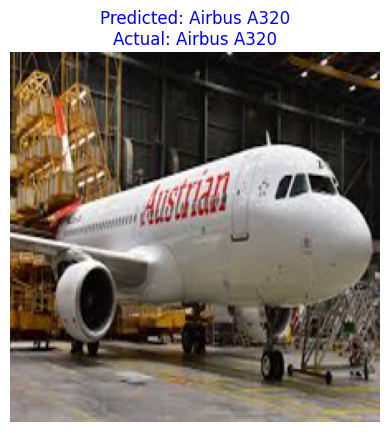

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


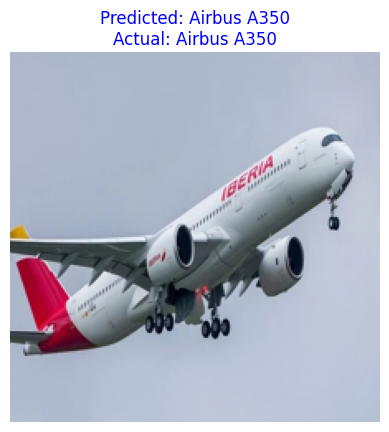

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


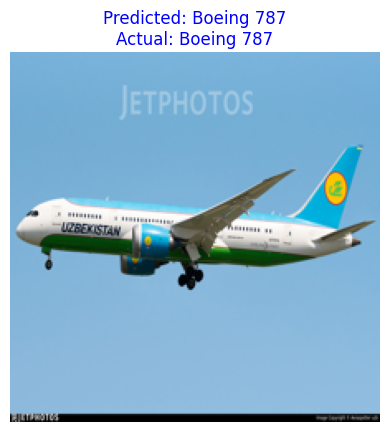

In [25]:
for i in [0,402,500]:
    show_prediction(best_model, X, y, index=i, class_labels=class_labels)